In this notebook, we'll get into the nitty gritty of supervised modeling based on our data exploration and feature engineering. As explained at the end of the last notebook, we'll be using two season cancellation rate as our metric - why? It doesn't suffer from too much class imbalance (see below baseline figure), which is useful when working with a small/medium sized dataset. Secondly, it's a better metric for show "failure" as we understand it than the same measure over one or three seasons.

The key metric we will use to evaluate the models is simply accuracy, since we are primarily aiming to find a model that most often correctly identifies whether or not a show survives past the second season. To add to our understanding and for application to holdouts later in the project, we'll also include recall/sensitivity (tp/(tp+fn)) and precision (tp/(tp+fp)).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import metrics
from scipy import stats
from sklearn.externals import joblib
shows = pd.read_pickle("cleaned_dataset_v4.pkl")
shows = shows[shows['status'] != 'Coming Soon']

In [2]:
# Narrowing down dataset to only those eligible for one year cancellation (eg before 2018)
no_na = shows.copy()
no_na = no_na[no_na['start_year'] < 2017]
no_na = no_na[(no_na['log_imdb_votes_per_season'].notnull()) & (no_na['imdb_rating'].notnull())]
no_na.to_pickle("no_na_pre2017_v4.pkl")
shows = shows[shows['start_year'] < 2017]
shows.to_pickle('cleaned_dataset_v4_pre2017')

In [3]:
baseline = no_na['two_season_cancel'].value_counts()[0]/len(no_na)
print('Baseline accuracy (dumb model): {0:.2%}'.format(baseline))

Baseline accuracy (dumb model): 57.45%


In [32]:
# Dataframe to house our results
#model_comp = pd.DataFrame(columns=['accuracy','precision','recall'])
#model_comp_imdb = pd.DataFrame(columns=['accuracy','precision','recall'])
model_comp = pd.read_pickle("Extras/model_comp.pkl")
model_comp_imdb = pd.read_pickle("Extras/model_comp_imdb.pkl")

### Logistic Regression
With the IMDB data

In [54]:
lrc = LogisticRegression()

In [7]:
X_imdb = pd.concat([pd.get_dummies(no_na[['network_type','rating_cat']].apply(lambda x: x.astype('O')))\
               ,no_na[['risky_2season','log_imdb_votes_per_season','imdb_rating','start_year']]],axis=1)
Y = no_na['two_season_cancel']

In [66]:
params = {'C': np.power(10,np.arange(-10,10).astype(float))
          ,'penalty':['l1','l2']}

In [67]:
GS_LRC = GridSearchCV(lrc,param_grid=params,scoring='accuracy',refit=True)

In [69]:
GS_LRC.fit(X_imdb,Y)
lrc_imdb_acc = GS_LRC.best_score_
print('LRC accuracy (grid-searched): {0:.2%}'.format(lrc_imdb_acc))

LRC accuracy (grid-searched): 87.54%


In [71]:
GS_LRC.best_params_

{'C': 100000000.0, 'penalty': 'l1'}

In [72]:
# Saving the final prediction results...
lrc_imdb_prec = cross_val_score(GS_LRC.best_estimator_,X_imdb,Y,scoring='precision').mean()
lrc_imdb_rec = cross_val_score(GS_LRC.best_estimator_,X_imdb,Y,scoring='recall').mean()

model_comp_imdb.loc['Regularized Logistic Regression'] = [lrc_imdb_acc,lrc_imdb_prec,lrc_imdb_rec]
model_comp_imdb

,accuracy,precision,recall
Regularized Logistic Regression,0.87538,0.889887,0.805436


Without the IMDB Data

In [42]:
X = pd.concat([pd.get_dummies(no_na[['network_type','country','tvmaze_ep_day','primary_genre']].apply(lambda x: x.astype('O')))\
               ,no_na[['risky_2season','start_year','quarter','month']]],axis=1)

In [43]:
GS_LRC = GridSearchCV(lrc,param_grid=params,scoring='accuracy',refit=True)

In [49]:
GS_LRC.fit(X,Y)
lrc_acc = GS_LRC.best_score_
print('LRC accuracy (grid-searched): {0:.2%}'.format(lrc_score))

LRC accuracy (grid-searched): 67.25%


In [51]:
lrc_prec = cross_val_score(GS_LRC.best_estimator_,X,Y,scoring='precision').mean()
lrc_rec = cross_val_score(GS_LRC.best_estimator_,X,Y,scoring='recall').mean()

In [53]:
# Saving the model results...
model_comp.loc['Regularized Logistic Regression'] = [lrc_acc,lrc_prec,lrc_rec]
model_comp

,accuracy,precision,recall
Regularized Logistic Regression,0.672492,0.615592,0.608964


### Random Forest
First with IMDB information

In [3]:
rfc = RandomForestClassifier()#(n_jobs=-1)

In [8]:
X_imdb = pd.concat([pd.get_dummies(no_na[['network_type','rating_cat','country','tvmaze_ep_day']].apply(lambda x: x.astype('O')))\
               ,no_na[['risky_2season','log_imdb_votes_per_season','imdb_rating','start_year']]],axis=1)

In [16]:
# Alternative feature set < the one to be used
X_imdb = pd.concat([pd.get_dummies(no_na[['network_type']].apply(lambda x: x.astype('O')))\
               ,no_na[['risky_2season','log_imdb_votes_per_season','imdb_rating','start_year']]],axis=1)

In [17]:
# Successive gridsearching
rf_params = {
    'n_estimators':np.arange(25,45,5),
    'max_features':['auto','log2','sqrt',None],
    'max_depth':np.append(np.array([None]),np.arange(2,11,1)),
    'min_samples_leaf':np.arange(1,5),
}

GS_RFC = GridSearchCV(rfc,param_grid=rf_params,scoring='accuracy',refit=True)

In [18]:
GS_RFC.fit(X_imdb,Y)
rfc_imdb_acc = GS_RFC.best_score_
print('RFC accuracy (grid-searched): {0:.2%}'.format(rfc_imdb_acc))

RFC accuracy (grid-searched): 90.73%


In [11]:
GS_RFC.best_params_

{'max_depth': 8,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'n_estimators': 30}

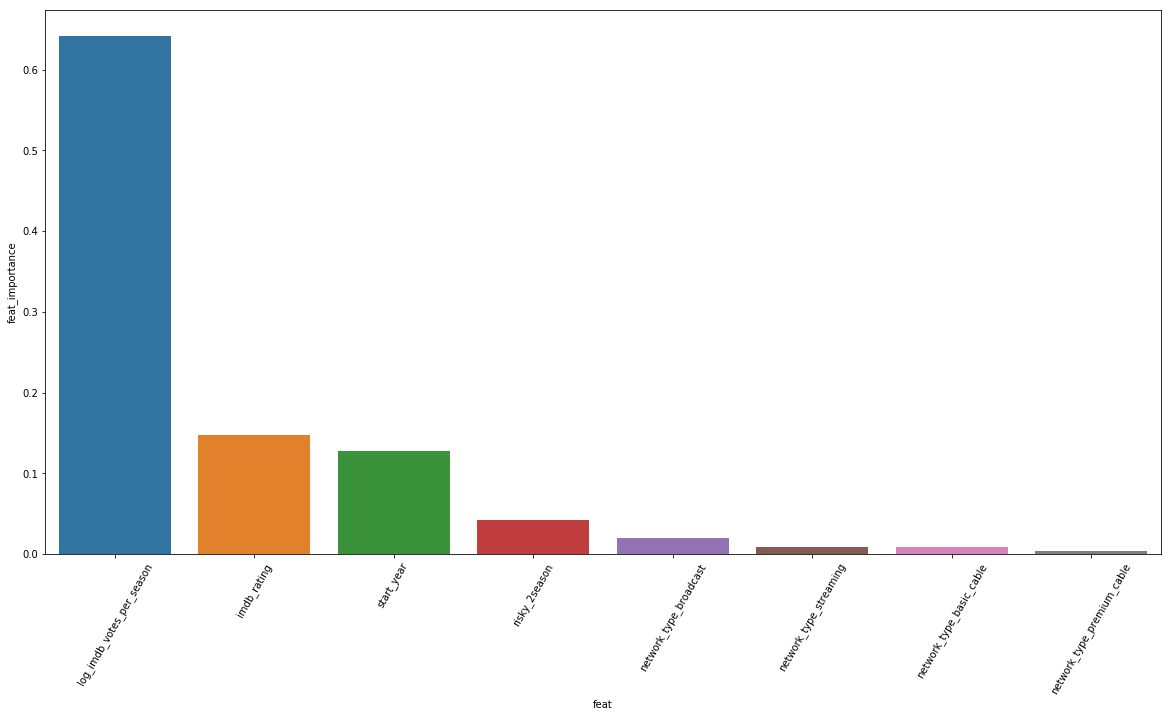

In [12]:
GS_RFC.estimator.fit(X_imdb,Y)

feat_impt_df = pd.DataFrame(data={'feat':X_imdb.columns,'feat_importance':GS_RFC.estimator.feature_importances_}).sort_values('feat_importance',ascending=False)
order = feat_impt_df.feat

plt.figure(figsize=(20,10))
sns.barplot(x='feat',y='feat_importance',data=feat_impt_df,order=order)
plt.xticks(rotation=60)
plt.show()

In [81]:
rfc_imdb_prec = cross_val_score(GS_RFC.best_estimator_,X_imdb,Y,scoring='precision').mean()
rfc_imdb_rec = cross_val_score(GS_RFC.best_estimator_,X_imdb,Y,scoring='recall').mean()

In [82]:
# Saving results
model_comp_imdb.loc['Random Forest Classifier'] = [rfc_imdb_acc,rfc_imdb_prec,rfc_imdb_rec]
model_comp_imdb

,accuracy,precision,recall
Regularized Logistic Regression,0.875380,0.889887,0.805436
Random Forest Classifier,0.907295,0.880020,0.875012


In [25]:
X_imdb.to_pickle("Extras/best_feat_x_imdb")

In [27]:
joblib.dump(GS_RFC,"Extras/GS_imdb_rfc.pkl")

['Extras/GS_imdb_rfc.pkl']

Now trying with different vars (no IMDB information)

In [85]:
X = pd.concat([pd.get_dummies(no_na[['network_type','country','tvmaze_ep_day','primary_genre']].apply(lambda x: x.astype('O')))\
               ,no_na[['risky_2season','start_year','quarter','month']]],axis=1)

In [86]:
# Successive gridsearching
rf_params = {
    'n_estimators':np.arange(25,45,5),
    'max_features':['auto','log2','sqrt',None],
    'max_depth':np.append(np.array([None]),np.arange(2,11,1)),
    'min_samples_leaf':np.arange(1,5),
}

GS_RFC = GridSearchCV(rfc,param_grid=rf_params,scoring='accuracy',refit=True)

In [88]:
GS_RFC.fit(X,Y)
rfc_acc = GS_RFC.best_score_
print('RFC accuracy (grid-searched): {0:.2%}'.format(rfc_acc))

RFC accuracy (grid-searched): 72.64%


In [89]:
GS_RFC.best_params_

{'max_depth': 6,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'n_estimators': 25}

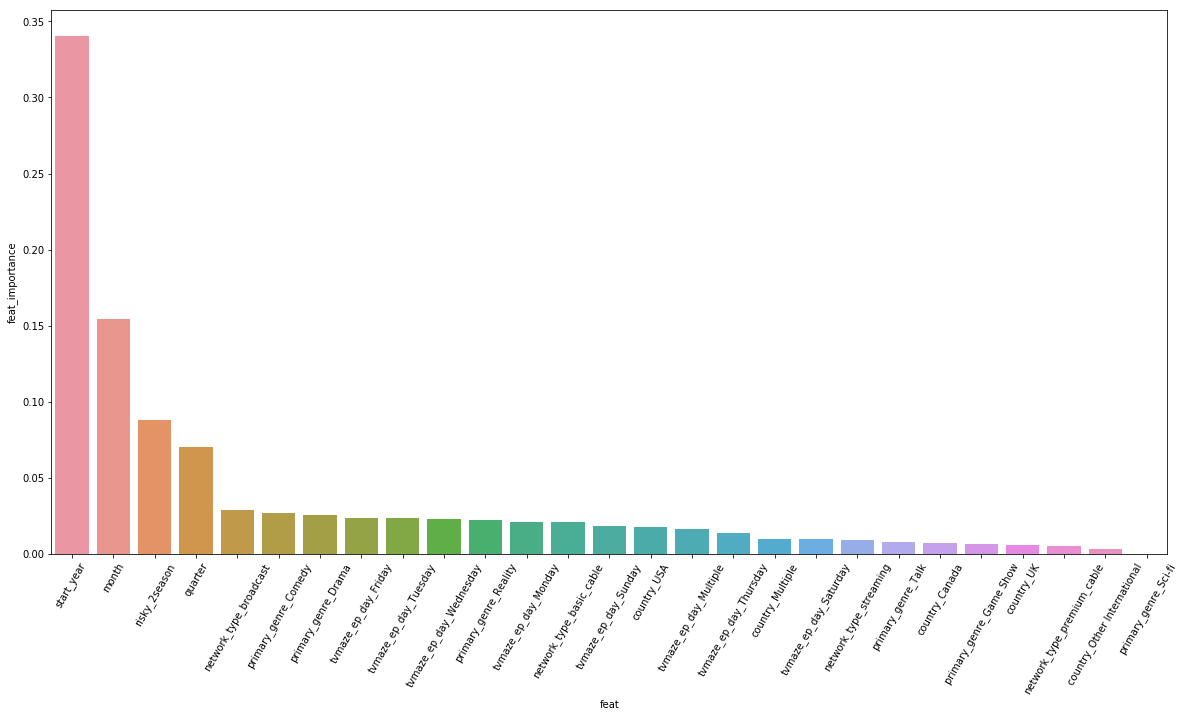

In [90]:
GS_RFC.estimator.fit(X,Y)

feat_impt_df = pd.DataFrame(data={'feat':X.columns,'feat_importance':GS_RFC.estimator.feature_importances_}).sort_values('feat_importance',ascending=False)
order = feat_impt_df.feat

plt.figure(figsize=(20,10))
sns.barplot(x='feat',y='feat_importance',data=feat_impt_df,order=order)
plt.xticks(rotation=60)
plt.show()

In [91]:
#Storing results
rfc_prec = cross_val_score(GS_RFC.best_estimator_,X,Y,scoring='precision').mean()
rfc_rec = cross_val_score(GS_RFC.best_estimator_,X,Y,scoring='recall').mean()

model_comp.loc['Random Forest Classifier'] = [rfc_acc,rfc_prec,rfc_rec]
model_comp

,accuracy,precision,recall
Regularized Logistic Regression,0.672492,0.615592,0.608964
Random Forest Classifier,0.726444,0.681582,0.63759


In [92]:
joblib.dump(GS_RFC,"Extras/GS_rfc.pkl")

['Extras/GS_rfc.pkl']

### Gradient Boosting
With the IMDB post-premiere data included...

In [93]:
gbc = GradientBoostingClassifier()

In [73]:
X_imdb = pd.concat([pd.get_dummies(no_na[['network_type']].apply(lambda x: x.astype('O')))\
               ,no_na[['risky_2season','log_imdb_votes_per_season','imdb_rating','start_year']]],axis=1)
Y_imdb = no_na['two_season_cancel']

In [74]:
# Successive gridsearching
gb_params = {
    'loss':['deviance','exponential'],
    'learning_rate':np.arange(0.1,1,0.1),
    'n_estimators':np.arange(20,50,10),
    'max_depth':np.append(np.array([None]),np.arange(1,11,1)),
}

GS_GBC = GridSearchCV(gbc,param_grid=gb_params,scoring='accuracy',refit=True)

In [75]:
GS_GBC.fit(X_imdb,Y_imdb)
gbc_imdb_acc = GS_GBC.best_score_
print('GBC accuracy (grid-searched): {0:.2%}'.format(gbc_imdb_acc))

GBC accuracy (grid-searched): 90.35%


In [71]:
GS_GBC.best_params_

{'learning_rate': 0.30000000000000004,
 'loss': 'deviance',
 'max_depth': 1,
 'n_estimators': 40}

In [329]:
X_imdb = pd.concat([pd.get_dummies(no_na[['network_type','rating_cat','primary_genre','tvmaze_ep_day']].apply(lambda x: x.astype('O')))\
               ,no_na[['risky_2season','log_imdb_votes_per_season','imdb_rating','start_year']]],axis=1)
Y_imdb = no_na['two_season_cancel']

In [330]:
# Successive gridsearching
gb_params = {
    'loss':['deviance','exponential'],
    'learning_rate':np.arange(0.8,1,0.25),
    'n_estimators':np.arange(10,40,10),
    'max_depth':np.append(np.array([None]),np.arange(1,11,1)),
}

GS_GBC = GridSearchCV(gbc,param_grid=gb_params,scoring='accuracy')

Trying a slightly modified feature set...

In [97]:
GS_GBC.fit(X_imdb,Y_imdb)
gbc_imdb_acc = GS_GBC.best_score_
print('GBC accuracy (grid-searched): {0:.2%}'.format(gbc_imdb_acc))

GBC accuracy (grid-searched): 90.35%


In [77]:
GS_GBC.best_params_

{'learning_rate': 0.2,
 'loss': 'exponential',
 'max_depth': 2,
 'n_estimators': 20}

In [100]:
# Storing results
gbc_imdb_prec = cross_val_score(GS_GBC.best_estimator_,X_imdb,Y,scoring='precision').mean()
gbc_imdb_rec = cross_val_score(GS_GBC.best_estimator_,X_imdb,Y,scoring='recall').mean()

model_comp_imdb.loc['Gradient Boosted Classifier'] = [gbc_imdb_acc,gbc_imdb_prec,gbc_imdb_rec]
model_comp_imdb

,accuracy,precision,recall
Regularized Logistic Regression,0.875380,0.889887,0.805436
Random Forest Classifier,0.907295,0.880020,0.875012
Gradient Boosted Classifier,0.903495,0.892928,0.878577


In [101]:
joblib.dump(GS_GBC,"Extras/GS_imdb_GBC.pkl")

['Extras/GS_imdb_GBC.pkl']

Now without the IMDB info...

In [58]:
gbc = GradientBoostingClassifier()

In [85]:
X = pd.concat([pd.get_dummies(no_na[['network_type','country','tvmaze_ep_day','primary_genre']].apply(lambda x: x.astype('O')))\
               ,no_na[['risky_2season','start_year','quarter','month']]],axis=1)
Y = no_na['two_season_cancel']

In [93]:
# Successive gridsearching
gb_params = {
    'loss':['deviance','exponential'],
    'learning_rate':np.arange(0.1,1,0.1),
    'n_estimators':np.arange(30,60,10),
    'max_depth':np.append(np.array([None]),np.arange(1,11,1)),
}

GS_GBC = GridSearchCV(gbc,param_grid=gb_params,scoring='accuracy',refit=True)

In [94]:
GS_GBC.fit(X,Y)
gbc_acc = GS_GBC.best_score_
print('GBC accuracy (grid-searched): {0:.2%}'.format(gbc_acc))

GBC accuracy (grid-searched): 72.87%


In [42]:
GS_GBC.best_params_

{'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 2, 'n_estimators': 30}

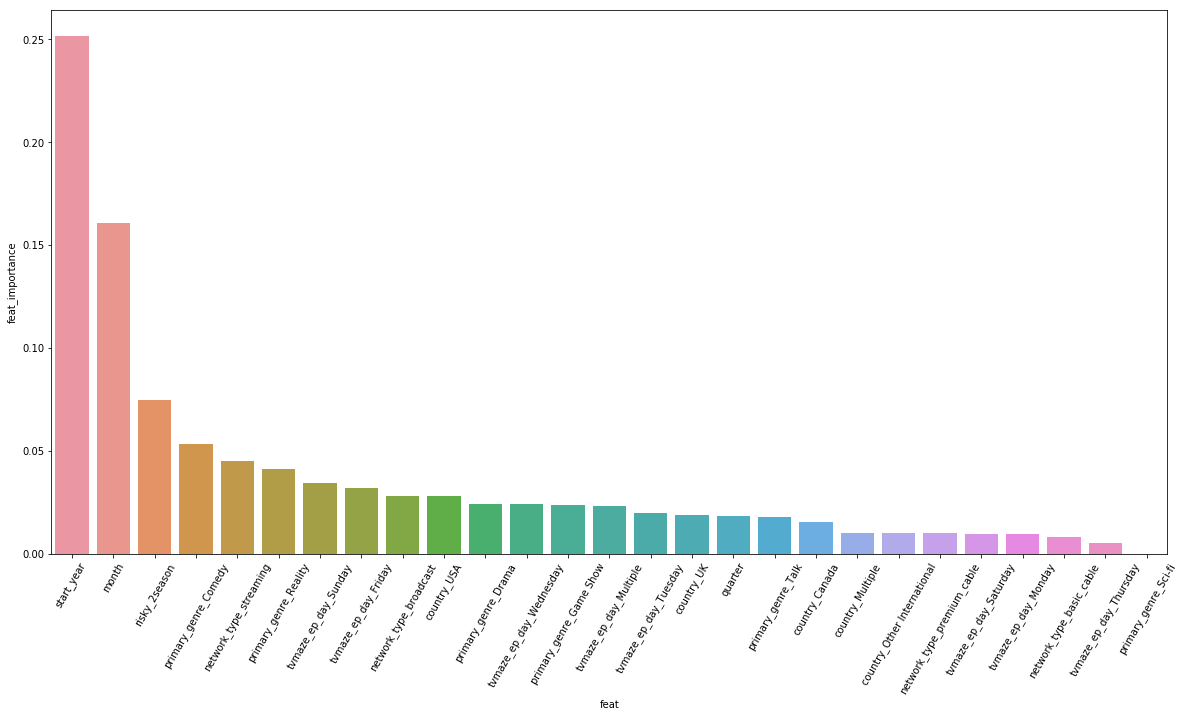

In [43]:
GS_GBC.estimator.fit(X,Y)

feat_impt_df = pd.DataFrame(data={'feat':X.columns,'feat_importance':GS_GBC.estimator.feature_importances_}).sort_values('feat_importance',ascending=False)
order = feat_impt_df.feat

plt.figure(figsize=(20,10))
sns.barplot(x='feat',y='feat_importance',data=feat_impt_df,order=order)
plt.xticks(rotation=60)
plt.show()

In [48]:
X.columns

Index(['network_type_basic_cable', 'network_type_broadcast',
       'network_type_premium_cable', 'network_type_streaming',
       'country_Canada', 'country_Multiple', 'country_Other International',
       'country_UK', 'country_USA', 'tvmaze_ep_day_Friday',
       'tvmaze_ep_day_Monday', 'tvmaze_ep_day_Multiple',
       'tvmaze_ep_day_Saturday', 'tvmaze_ep_day_Sunday',
       'tvmaze_ep_day_Thursday', 'tvmaze_ep_day_Tuesday',
       'tvmaze_ep_day_Wednesday', 'primary_genre_Comedy',
       'primary_genre_Drama', 'primary_genre_Game Show',
       'primary_genre_Reality', 'primary_genre_Sci-fi', 'primary_genre_Talk',
       'risky_2season', 'start_year', 'quarter', 'month'],
      dtype='object')

In [44]:
#Storing results
gbc_prec = cross_val_score(GS_GBC.best_estimator_,X,Y,scoring='precision').mean()
gbc_rec = cross_val_score(GS_GBC.best_estimator_,X,Y,scoring='recall').mean()

model_comp.loc['Gradient Boosted Classifier'] = [gbc_acc,gbc_prec,gbc_rec]
model_comp

,accuracy,precision,recall
Regularized Logistic Regression,0.672492,0.615592,0.608964
Random Forest Classifier,0.726444,0.681582,0.63759
Gradient Boosted Classifier,0.728723,0.689536,0.659029
SVM Classifier,0.723404,0.678964,0.664367


In [124]:
joblib.dump(GS_GBC,"Extras/GS_GBC.pkl")

['Extras/GS_GBC.pkl']

In [4]:
X.to_pickle("Extras/best_feat_x")
Y.to_pickle("Extras/y")

### SVM
With the IMDB information...

In [128]:
svc = SVC()

In [129]:
from sklearn.preprocessing import MinMaxScaler

# Scaling/normalization required for SVM to function correctly
X_imdb = pd.concat([pd.get_dummies(no_na[['network_type','country','tvmaze_ep_day','primary_genre','rating_cat']].apply(lambda x: x.astype('O'))).reset_index(drop=True)\
               ,no_na[['risky_2season','start_year','imdb_rating','log_imdb_votes_per_season']].reset_index(drop=True)\
           ,pd.DataFrame(MinMaxScaler().fit_transform(no_na[['quarter','month']])\
                         ,columns=['quarter','month'])],axis=1)
Y = no_na['two_season_cancel']

In [130]:
# Successive gridsearching
svc_params = {
    'C':np.power(10,np.arange(-2,2).astype(float)),
    'kernel':['rbf']
}

GS_SVC = GridSearchCV(svc,param_grid=svc_params,scoring='accuracy',refit=True)

In [131]:
GS_SVC.fit(X_imdb,Y)
svc_imdb_acc = GS_SVC.best_score_
print('SVC accuracy (grid-searched): {0:.2%}'.format(svc_imdb_acc))

SVC accuracy (grid-searched): 90.43%


In [132]:
GS_SVC.best_params_

{'C': 10.0, 'kernel': 'rbf'}

In [133]:
# Storing results
svc_imdb_prec = cross_val_score(GS_SVC.best_estimator_,X_imdb,Y,scoring='precision').mean()
svc_imdb_rec = cross_val_score(GS_SVC.best_estimator_,X_imdb,Y,scoring='recall').mean()

model_comp_imdb.loc['SVM Classifier'] = [svc_imdb_acc,svc_imdb_prec,svc_imdb_rec]
model_comp_imdb

,accuracy,precision,recall
Regularized Logistic Regression,0.875380,0.889887,0.805436
Random Forest Classifier,0.907295,0.880020,0.875012
Gradient Boosted Classifier,0.903495,0.892928,0.878577
SVM Classifier,0.904255,0.893174,0.880398


In [134]:
joblib.dump(GS_SVC,"Extras/GS_imdb_SVC.pkl")

['Extras/GS_imdb_SVC.pkl']

In [135]:
model_comp_imdb.to_pickle("Extras/model_comp_imdb.pkl")

Without the IMDB information....

In [161]:
svc = SVC()

In [162]:
from sklearn.preprocessing import MinMaxScaler

# Scaling/normalization required for SVM to function correctly
X = pd.concat([pd.get_dummies(no_na[['network_type','country','tvmaze_ep_day','primary_genre']].apply(lambda x: x.astype('O'))).reset_index(drop=True)\
               ,no_na[['risky_2season','start_year']].reset_index(drop=True)\
           ,pd.DataFrame(MinMaxScaler().fit_transform(no_na[['quarter','month']])\
                         ,columns=['quarter','month'])],axis=1)
Y = no_na['two_season_cancel']

In [163]:
# Successive gridsearching
svc_params = {
    'C':np.power(10,np.arange(-2,2).astype(float)),
    'kernel':['rbf']
}

GS_SVC = GridSearchCV(svc,param_grid=svc_params,scoring='accuracy',refit=True)

In [164]:
GS_SVC.fit(X,Y)
svc_acc = GS_SVC.best_score_
print('SVC accuracy (grid-searched): {0:.2%}'.format(svc_acc))

SVC accuracy (grid-searched): 72.34%


In [165]:
GS_SVC.best_params_

{'C': 1.0, 'kernel': 'rbf'}

In [166]:
#Storing results
svc_prec = cross_val_score(GS_SVC.best_estimator_,X,Y,scoring='precision').mean()
svc_rec = cross_val_score(GS_SVC.best_estimator_,X,Y,scoring='recall').mean()

model_comp.loc['SVM Classifier'] = [svc_acc,svc_prec,svc_rec]
model_comp

,accuracy,precision,recall
Regularized Logistic Regression,0.672492,0.615592,0.608964
Random Forest Classifier,0.726444,0.681582,0.63759
Gradient Boosted Classifier,0.728723,0.689536,0.659029
SVM Classifier,0.723404,0.678964,0.664367


In [167]:
joblib.dump(GS_SVC,"Extras/GS_svc.pkl")

['Extras/GS_svc.pkl']

In [168]:
model_comp.to_pickle("Extras/model_comp.pkl")

### Let's see if PCA modifications of our best model type leads to any decrease in overfitting
Starting with an arbitrary number of about half of features (15) as the number of components

In [60]:
gbc = GradientBoostingClassifier()

In [62]:
X = pd.concat([pd.get_dummies(no_na[['network_type','country','tvmaze_ep_day','primary_genre']].apply(lambda x: x.astype('O')))\
               ,no_na[['risky_2season','start_year','quarter','month']]],axis=1)
Y = no_na['two_season_cancel']

In [63]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=15)
X_pca = pca.fit_transform(X)

In [64]:
# Successive gridsearching
gb_params = {
    'loss':['deviance','exponential'],
    'learning_rate':np.arange(0.1,1,0.1),
    'n_estimators':np.arange(30,60,10),
    'max_depth':np.append(np.array([None]),np.arange(1,11,1)),
}

GS_GBC = GridSearchCV(gbc,param_grid=gb_params,scoring='accuracy',refit=True)

In [66]:
GS_GBC.fit(X_pca,Y)
gbc_acc = GS_GBC.best_score_
print('GBC accuracy (grid-searched): {0:.2%}'.format(gbc_acc))

GBC accuracy (grid-searched): 71.12%


In [67]:
GS_GBC.best_params_

{'learning_rate': 0.30000000000000004,
 'loss': 'deviance',
 'max_depth': 1,
 'n_estimators': 40}

No improvement. Let's see if that changes with all possible permutations.

In [76]:
components = np.arange(1,27)
avg_scores = []

for comp in components:
    X_scaled = StandardScaler().fit_transform(X)
    pca = PCA(n_components=comp)
    X_pca = pca.fit_transform(X)

    GS_GBC.fit(X_pca,Y)
    gbc_acc = GS_GBC.best_score_
    
    avg_scores.append(gbc_acc)

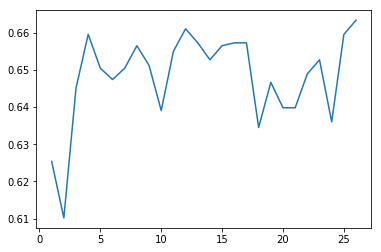

In [69]:
plt.plot(components,avg_scores)
plt.show()

None of these produce an accuracy above 66%, which is quite a bit worse than our 73% without it. Let's avoid using PCA on the original feature set.

Just messing with Naive Bayes for fun...

In [78]:
from sklearn.naive_bayes import BernoulliNB

In [83]:
nb = BernoulliNB(0.5)

In [84]:
cross_val_score(nb,X,Y)

array([0.68109339, 0.64236902, 0.64611872])